In [3]:
from google.colab import files
uploaded = files.upload()

Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set (1).csv


In [4]:
# --- 2) Kütüphaneler ve yardımcı fonksiyonlar ---
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
%matplotlib inline

plt.rcParams['figure.figsize'] = (8,6)
sns.set(style='whitegrid')

def plot_confusion(cm, labels=['Normal','Attack'], title='Confusion Matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)

def safe_head(df, n=5):
    try:
        display(df.head(n))
    except Exception as e:
        print(e)

In [5]:
# --- 3) Veri yükleme ---
data_path = 'UNSW_NB15_training-set.csv'
df = pd.read_csv(data_path)
print('Yüklendi:', data_path)
print('Satır sayısı:', len(df), 'Sütun sayısı:', len(df.columns))
safe_head(df)

Yüklendi: UNSW_NB15_training-set.csv
Satır sayısı: 175341 Sütun sayısı: 45


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
# 2000 normal, 500 attack örnek seçme
import numpy as np

normal_idx = df[df['label'] == 0].index
attack_idx = df[df['label'] == 1].index

np.random.seed(42)
sel_norm = np.random.choice(normal_idx, size=2000, replace=False)
sel_attk = np.random.choice(attack_idx, size=500, replace=False)

sel_idx = np.concatenate([sel_norm, sel_attk])
df_sample = df.loc[sel_idx].reset_index(drop=True)

# Sayısal sütunlar + label
numeric_df = df_sample.select_dtypes(include=[np.number]).copy()
y_true = df_sample['label'].values

In [7]:
# --- 4) Keşif: Genel bilgi, eksikler, dtype'lar ---
print('Sütun tipleri:')
print(df.dtypes.value_counts())
print('\nÖrnek sütun isimleri:', list(df.columns)[:30])

# Eksik değerler
missing = df.isnull().sum()
missing = missing[missing>0]
print('\nEksik sütunlar (varsa):\n', missing)

# Eğer kategorik sütunlar varsa kısa özet
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print('\nKategorik sütunlar (ilk 10):', cat_cols[:10])

# Özet istatistik
safe_head(df.describe(include='all'))

Sütun tipleri:
int64      30
float64    11
object      4
Name: count, dtype: int64

Örnek sütun isimleri: ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth']

Eksik sütunlar (varsa):
 Series([], dtype: int64)

Kategorik sütunlar (ilk 10): ['proto', 'service', 'state', 'attack_cat']


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,175341.0,175341.000000,175341,175341,175341,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341,175341.000000
unique,NaN,NaN,133,13,9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,INT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,79946,94168,82275,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56000,NaN
mean,87671.0,1.359389,NaN,NaN,NaN,20.298664,18.969591,8844.843836,14928.918564,95406.187105,...,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,NaN,0.680622


In [8]:
# --- 5) Etiket belirleme ve sadece sayısal sütunlar ---
possible_label_cols = [c for c in df.columns if c.lower() in ('label','attack','class','binary_label','is_attack','attack_cat')]
label_col = None
for c in possible_label_cols:
    if c in df.columns:
        label_col = c
        break

if label_col is None and 'attack_cat' in df.columns:
    label_col = 'attack_cat'
    df['binary_label'] = (df['attack_cat'] != 'Normal').astype(int)
    label_col = 'binary_label'

if label_col is None:
    raise ValueError('Etiket sütunu bulunamadı otomatik olarak. Lütfen notebook içinde label_col ataması yapın.')

print('Etiket sütunu:', label_col)

# Sayısal sütunlar
numeric_df = df.select_dtypes(include=[np.number]).copy()

if label_col in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=[label_col])


print('Sayısal sütun sayısı:', numeric_df.shape[1])

Etiket sütunu: attack_cat
Sayısal sütun sayısı: 41


In [9]:
# --- 5.1) Eksik verileri temizleme ---
numeric_df = numeric_df.dropna()

# --- 5.2) Ölçekleme ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df.drop(columns=['label'], errors='ignore'))


In [10]:
# --- 6) Örnekleme: normal=2000, attack=500 ---


if set(df[label_col].unique()) <= {0,1}:
    normal_df = df[df[label_col]==0]
    attack_df = df[df[label_col]==1]
else:
    normal_df = df[df[label_col]=='Normal']
    attack_df = df[df[label_col] != 'Normal']

print('Normal örnek sayısı (toplam):', len(normal_df))
print('Attack örnek sayısı (toplam):', len(attack_df))

np.random.seed(42)
normal_sample = normal_df.sample(n=min(2000, len(normal_df)), random_state=42)
attack_sample = attack_df.sample(n=min(500, len(attack_df)), random_state=42)

sampled = pd.concat([normal_sample, attack_sample], ignore_index=True).sample(frac=1, random_state=42)

numeric_df_sampled = sampled.select_dtypes(include=[np.number]).copy()
if label_col in numeric_df_sampled.columns:
    numeric_df_sampled = numeric_df_sampled.drop(columns=[label_col])


print('Örneklenmiş toplam:', sampled.shape)

safe_head(sampled)

Normal örnek sayısı (toplam): 56000
Attack örnek sayısı (toplam): 119341
Örneklenmiş toplam: (2500, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
1447,7340,0.129879,tcp,-,FIN,22,14,1470,1728,269.481599,...,1,1,0,0,0,3,4,0,Normal,0
1114,10657,0.001082,udp,dns,CON,2,2,146,178,2772.643321,...,1,2,0,0,0,3,1,0,Normal,0
1064,88120,0.911939,tcp,-,FIN,10,8,2516,354,18.641597,...,1,3,0,0,0,3,3,0,Normal,0
2287,55946,0.000003,bbn-rcc,-,INT,2,0,180,0,333333.321500,...,9,10,0,0,0,9,10,0,DoS,1
1537,24063,0.029773,tcp,-,FIN,48,50,2958,32642,3257.985354,...,1,4,0,0,0,6,8,0,Normal,0


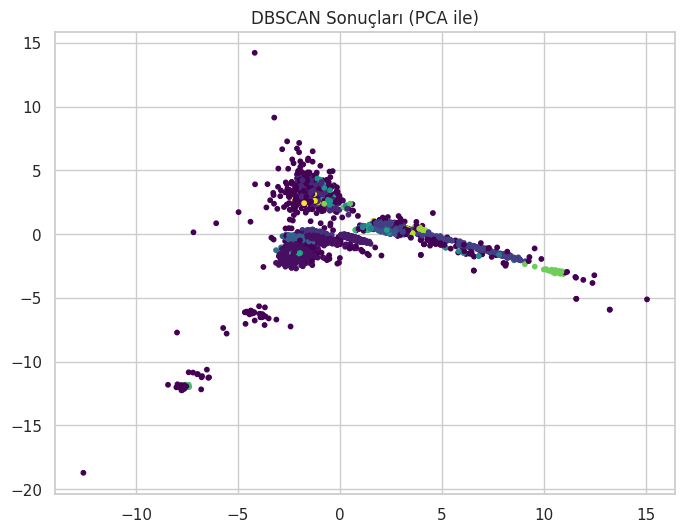

DBSCAN Sonuçları:
[[1651  349]
 [ 316  184]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      2000
           1       0.35      0.37      0.36       500

    accuracy                           0.73      2500
   macro avg       0.59      0.60      0.59      2500
weighted avg       0.74      0.73      0.74      2500



In [11]:
# --- 7) DBSCAN ---
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df_sampled)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

# PCA ile görselleştirme
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, cmap='viridis', s=10)
plt.title("DBSCAN Sonuçları (PCA ile)")
plt.show()

y_binary = (sampled[label_col] != 'Normal').astype(int)

print("DBSCAN Sonuçları:")
print(confusion_matrix(y_binary, db_labels == -1))
print(classification_report(y_binary, db_labels == -1, zero_division=0))

In [12]:
# --- 8) Isolation Forest ---
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=500/2500, random_state=42)
iso_labels = iso.fit_predict(X_scaled)

# IsolationForest: -1 -> anomali, 1 -> normal
iso_preds = (iso_labels == -1).astype(int)

print("Isolation Forest Sonuçları:")
print(confusion_matrix(y_true, iso_preds))
print(classification_report(y_true, iso_preds))


Isolation Forest Sonuçları:
[[1606  394]
 [ 396  104]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2000
           1       0.21      0.21      0.21       500

    accuracy                           0.68      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.68      0.68      0.68      2500



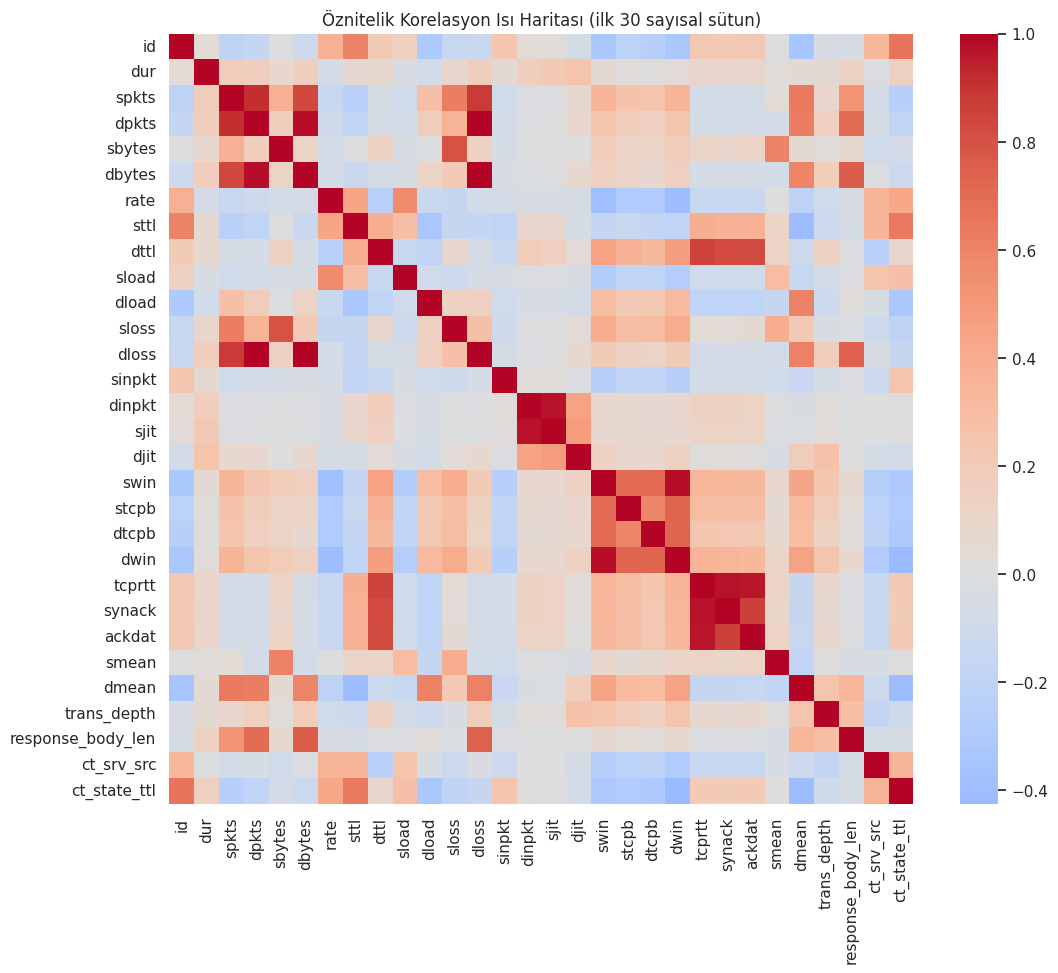

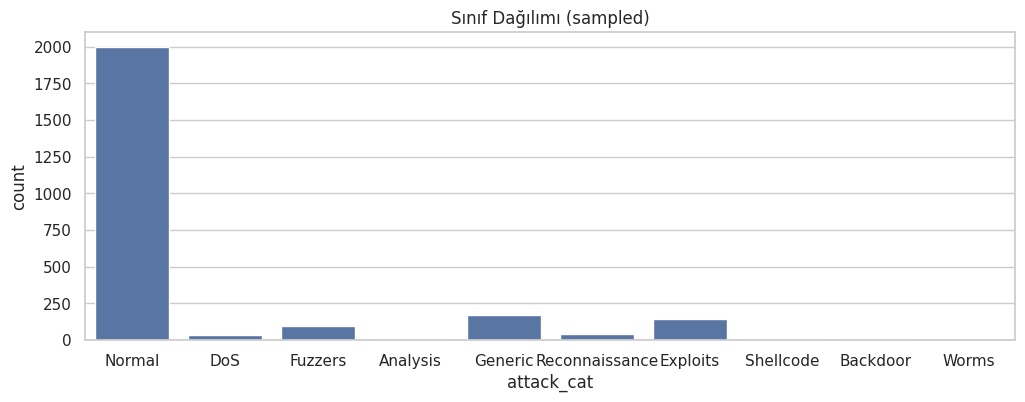

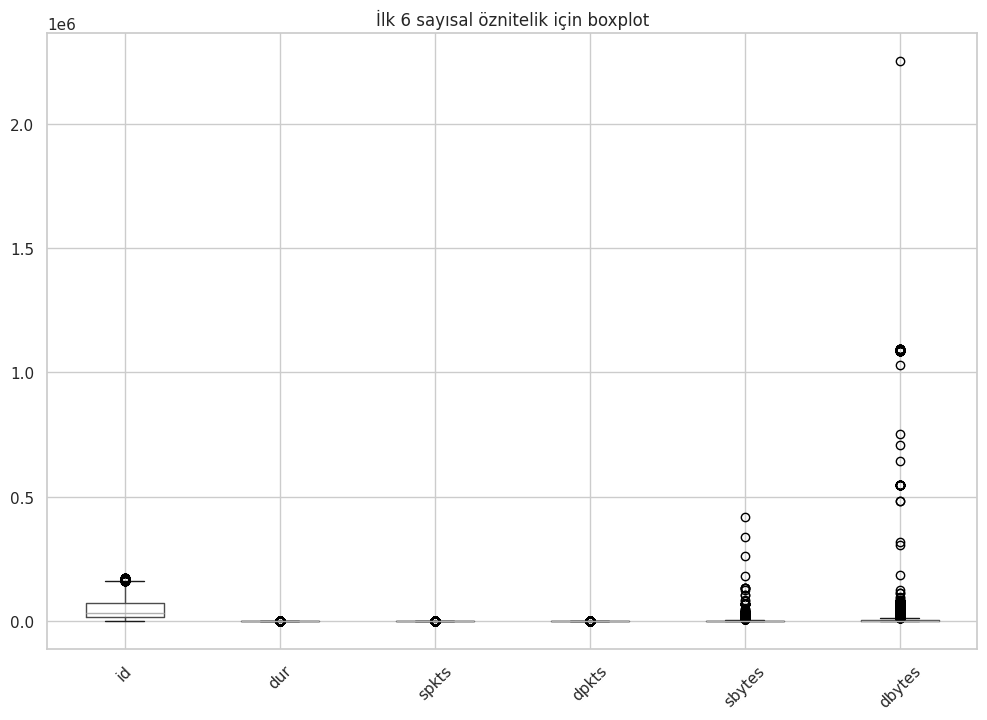

In [13]:
# --- 9) Görselleştirmeler: Korelasyon, dağılımlar, boxplotlar ---
X = sampled.drop(columns=[label_col])
y = sampled[label_col]

# Korel asyon ısı haritası (ilk 30 öznitelik için, yoksa hepsi)
cols = X.select_dtypes(include=[np.number]).columns[:30]
plt.figure(figsize=(12,10))
sns.heatmap(X[cols].corr(), cmap='coolwarm', center=0)
plt.title('Öznitelik Korelasyon Isı Haritası (ilk 30 sayısal sütun)')

# Her sütun için dağılım ya da boxplot (çok sütun varsa az sayıda örnek göster)
plt.figure(figsize=(12,4))
sns.countplot(x=y)
plt.title('Sınıf Dağılımı (sampled)')

# Basit boxplot örneği: ilk 6 sayısal sütun
plt.figure(figsize=(12,8))
numeric_cols_X = X.select_dtypes(include=[np.number]).columns
cols6 = numeric_cols_X[:6]
if not cols6.empty:
    X[cols6].boxplot(rot=45)
    plt.title('İlk 6 sayısal öznitelik için boxplot')
else:
    print("Kutu grafiğini çizecek sayısal sütun yok.")

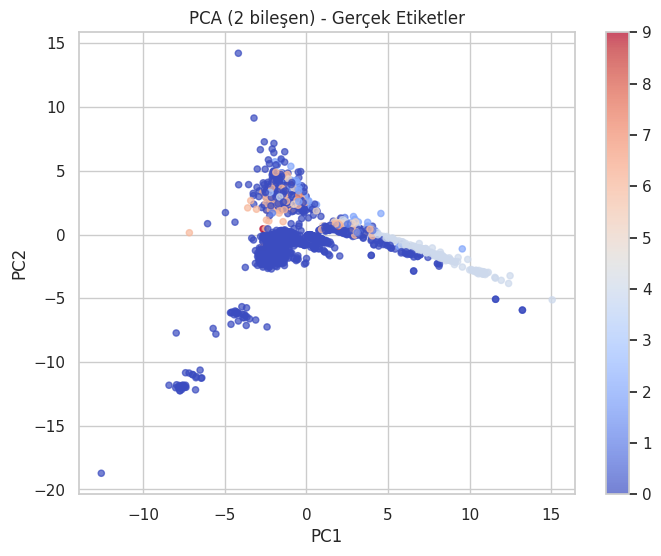

In [15]:
# --- 10) PCA ile 2-boyutlu görselleştirme ---
X = sampled.drop(columns=[label_col])
X_numeric = X.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=pd.factorize(y)[0], cmap='coolwarm', s=20, alpha=0.7)
plt.title('PCA (2 bileşen) - Gerçek Etiketler')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.colorbar();


--- DBSCAN eps=0.30 min_samples=5 ---
              precision    recall  f1-score   support

           0     1.0000    0.1165    0.2087      2000
           1     0.0150    1.0000    0.0296        34
           2     0.0000    0.0000    0.0000        93
           3     0.0000    0.0000    0.0000         7
           4     0.0000    0.0000    0.0000       173
           5     0.0000    0.0000    0.0000        38
           6     0.0000    0.0000    0.0000       140
           7     0.0000    0.0000    0.0000         6
           8     0.0000    0.0000    0.0000         8
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.1068      2500
   macro avg     0.1015    0.1116    0.0238      2500
weighted avg     0.8002    0.1068    0.1674      2500


--- DBSCAN eps=0.30 min_samples=10 ---
              precision    recall  f1-score   support

           0     1.0000    0.0835    0.1541      2000
           1     0.0146    1.0000    0.0287        34

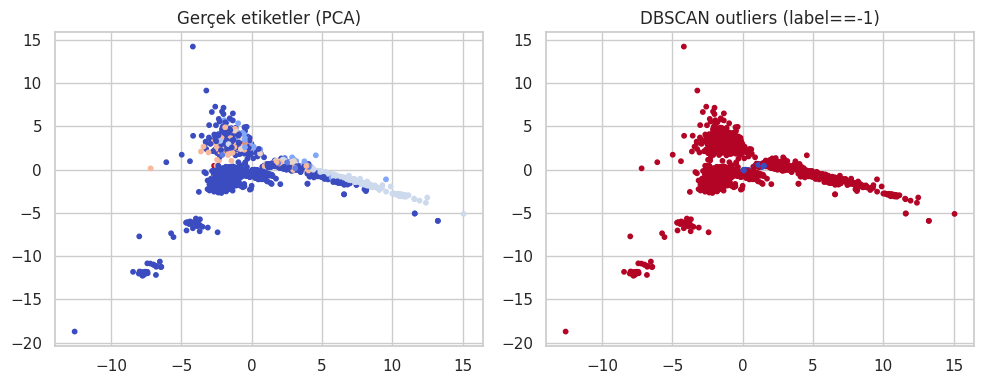

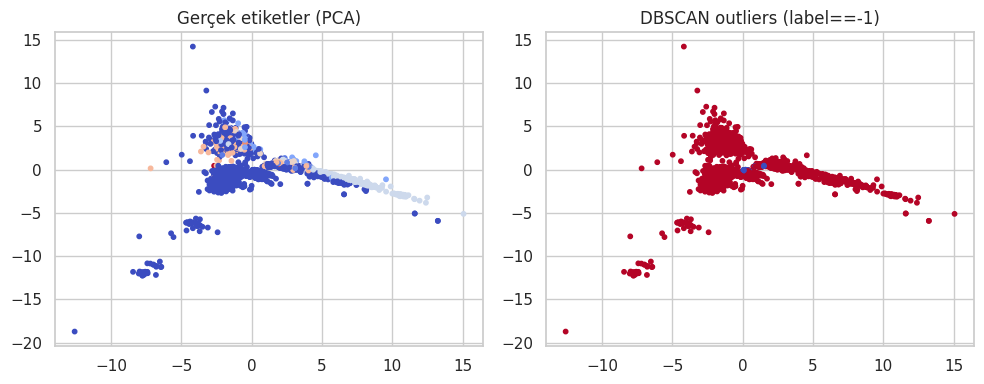

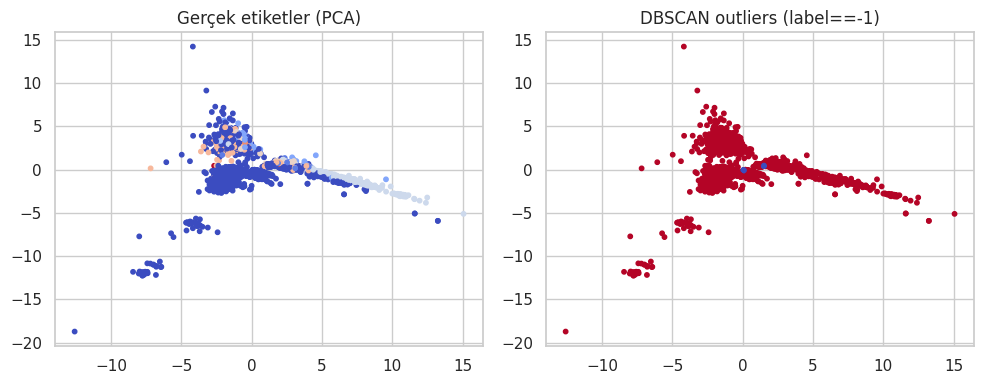

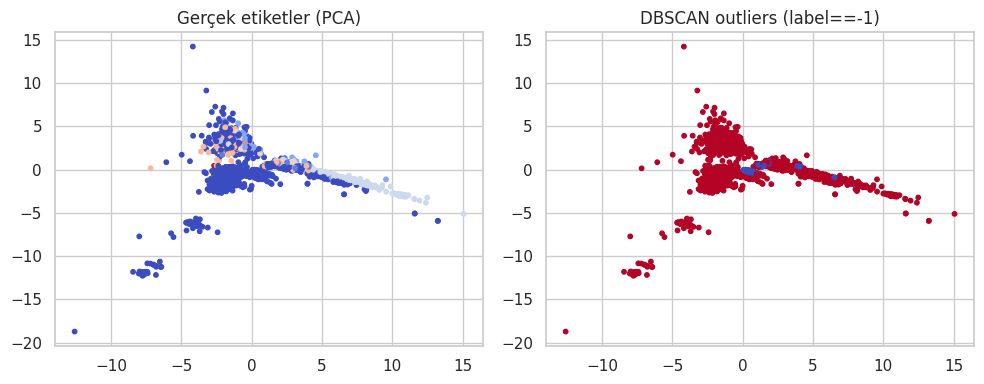

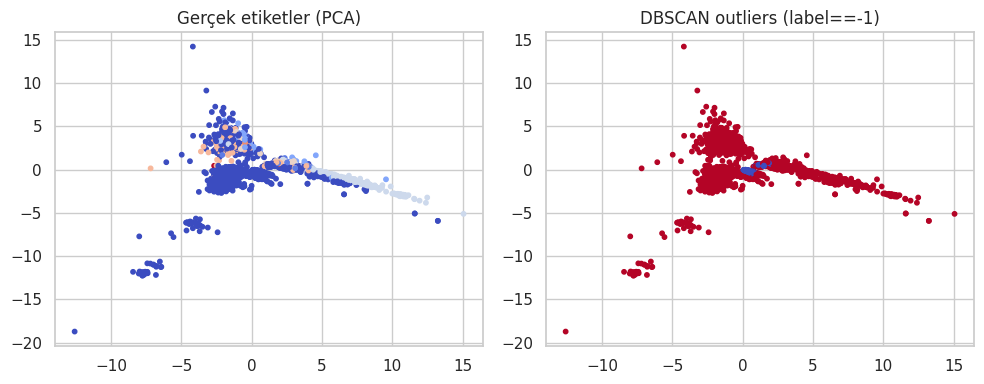

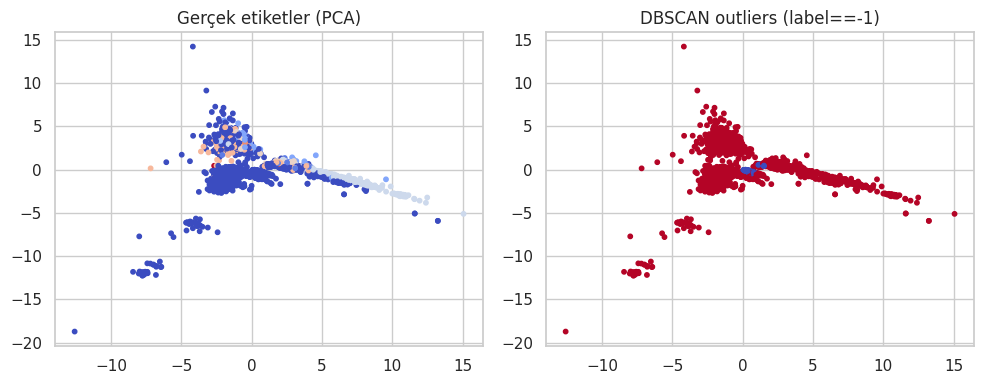

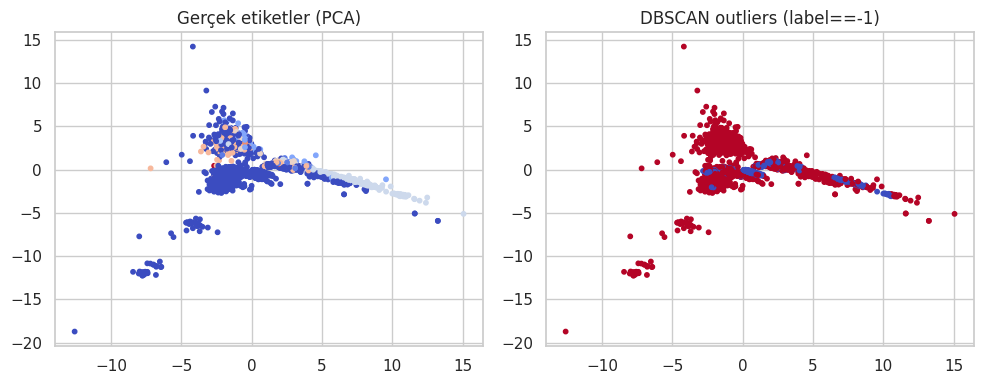

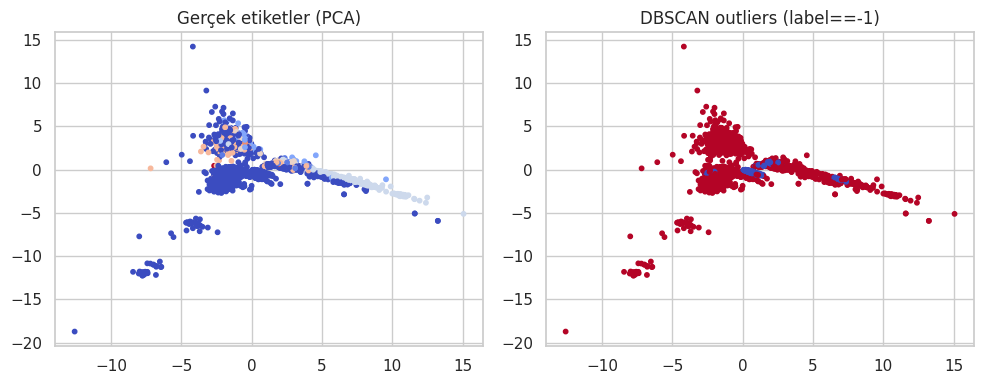

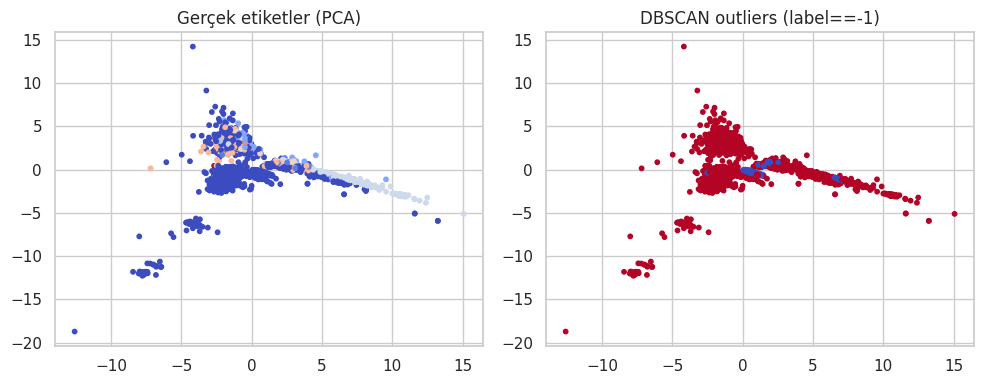

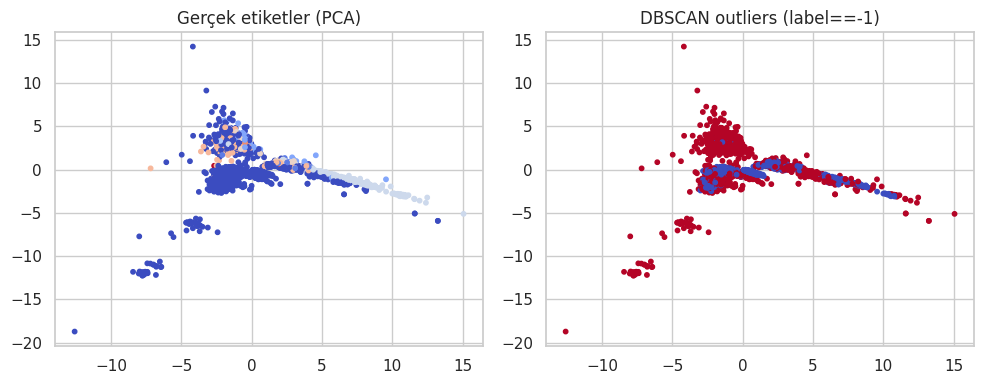

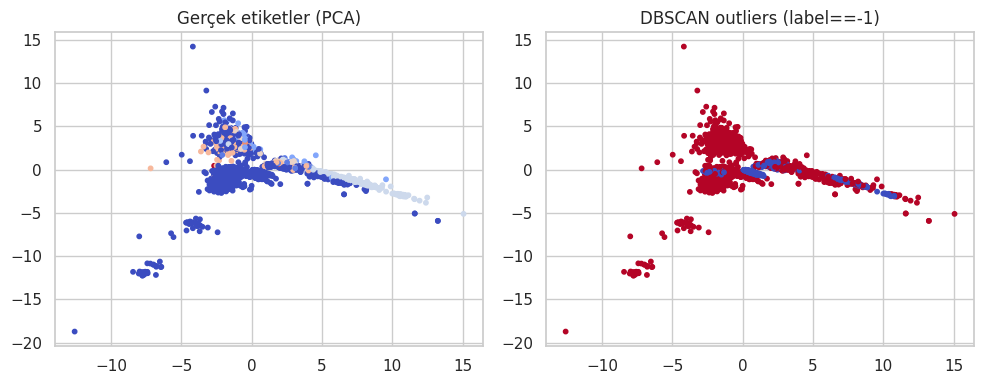

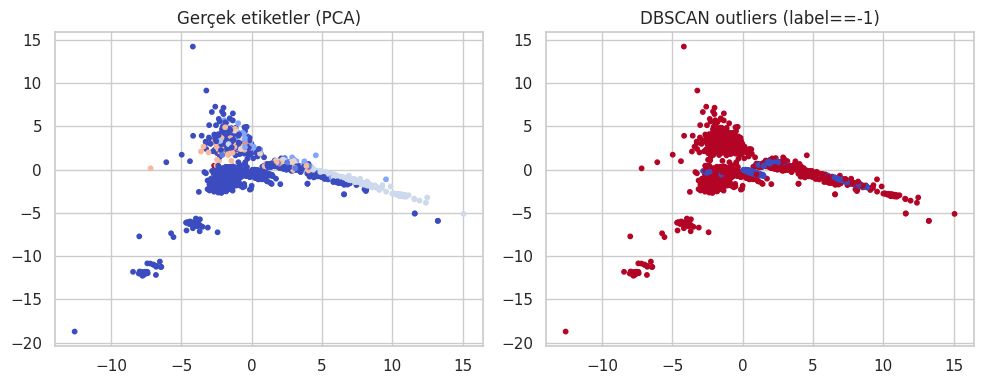

In [16]:
# --- 11) DBSCAN: Parametre taraması, PCA görünümü ve metrikler ---
from sklearn.metrics import classification_report, confusion_matrix

def dbscan_experiment(X_scaled, X_pca, y, eps_list=[0.3,0.5,0.8,1.0], min_samples_list=[5,10,15]):
    results = {}

    y_numeric = pd.factorize(y)[0]
    for eps in eps_list:
        for ms in min_samples_list:
            db = DBSCAN(eps=eps, min_samples=ms)
            labels = db.fit_predict(X_scaled)
            pred = (labels == -1).astype(int)

            cm = confusion_matrix(y_numeric, pred)
            report = classification_report(y_numeric, pred, digits=4, zero_division=0)
            key = (eps,ms)
            results[key] = {'cm':cm, 'report':report, 'labels':labels}
            print('\n--- DBSCAN eps=%.2f min_samples=%d ---' % (eps,ms))
            print(report)

            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.title('Gerçek etiketler (PCA)')
            plt.scatter(X_pca[:,0], X_pca[:,1], c=y_numeric, cmap='coolwarm', s=10)
            plt.subplot(1,2,2)
            plt.title('DBSCAN outliers (label==-1)')
            plt.scatter(X_pca[:,0], X_pca[:,1], c=(labels==-1), cmap='coolwarm', s=10)
            plt.tight_layout()
    return results

results_db = dbscan_experiment(X_scaled, X_pca, y)


--- IsolationForest contamination=0.010 ---
              precision    recall  f1-score   support

           0     0.7984    0.9880    0.8831      2000
           1     0.0000    0.0000    0.0000        34
           2     0.0000    0.0000    0.0000        93
           3     0.0000    0.0000    0.0000         7
           4     0.0000    0.0000    0.0000       173
           5     0.0000    0.0000    0.0000        38
           6     0.0000    0.0000    0.0000       140
           7     0.0000    0.0000    0.0000         6
           8     0.0000    0.0000    0.0000         8
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.7904      2500
   macro avg     0.0798    0.0988    0.0883      2500
weighted avg     0.6387    0.7904    0.7065      2500


--- IsolationForest contamination=0.030 ---
              precision    recall  f1-score   support

           0     0.8021    0.9725    0.8791      2000
           1     0.0000    0.0000    0.000

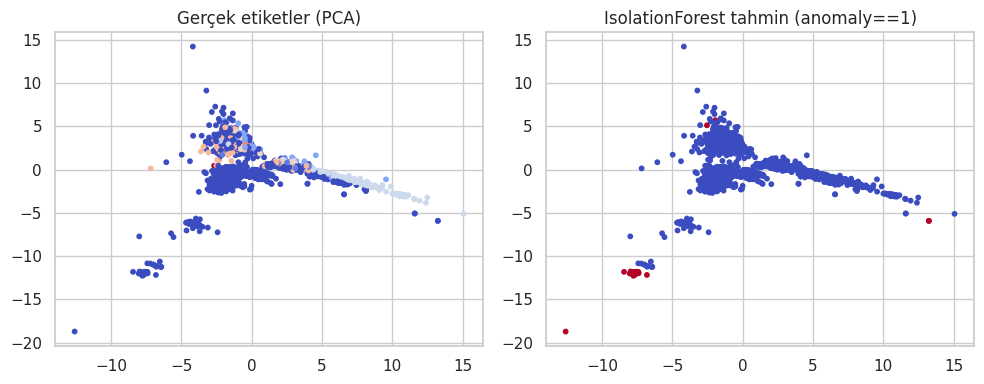

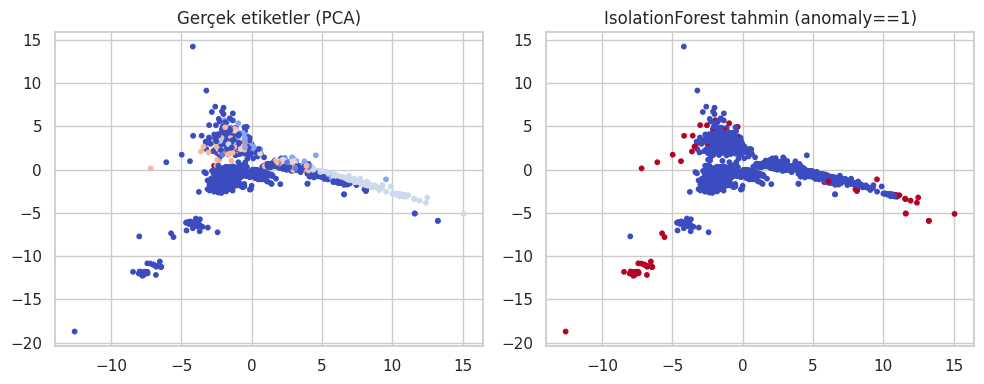

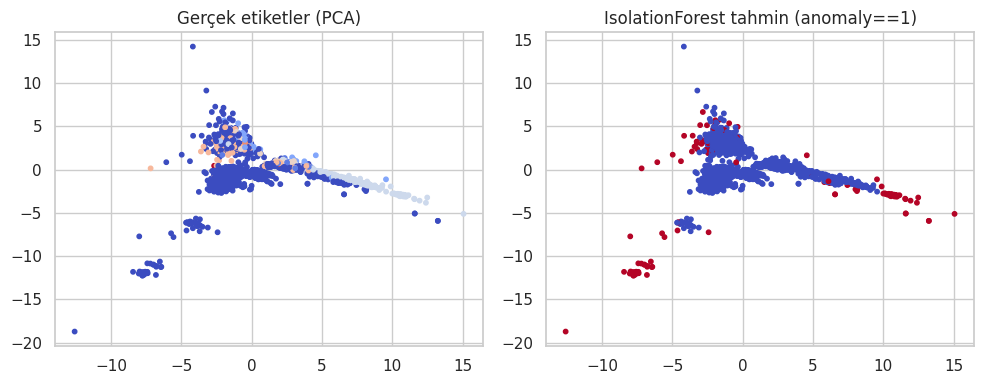

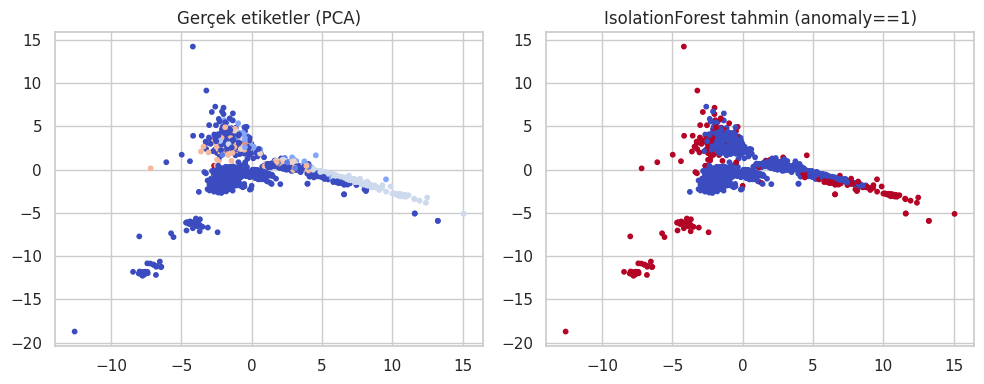

In [17]:
# --- 12) IsolationForest: Contamination sweep, metrikler ve PCA görselleştirme ---
iso_results = {}

y_numeric = pd.factorize(y)[0]
for cont in [0.01, 0.03, 0.05, 0.1]:
    iso = IsolationForest(contamination=cont, random_state=42)
    iso.fit(X_scaled)
    pred_iso = iso.predict(X_scaled)
    pred = (pred_iso == -1).astype(int)
    cm = confusion_matrix(y_numeric, pred)
    report = classification_report(y_numeric, pred, digits=4, zero_division=0)
    iso_results[cont] = {'cm':cm, 'report':report, 'pred':pred}
    print('\n--- IsolationForest contamination=%.3f ---' % cont)
    print(report)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title('Gerçek etiketler (PCA)')
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y_numeric, cmap='coolwarm', s=10)
    plt.subplot(1,2,2)
    plt.title('IsolationForest tahmin (anomaly==1)')
    plt.scatter(X_pca[:,0], X_pca[:,1], c=pred, cmap='coolwarm', s=10)
    plt.tight_layout()

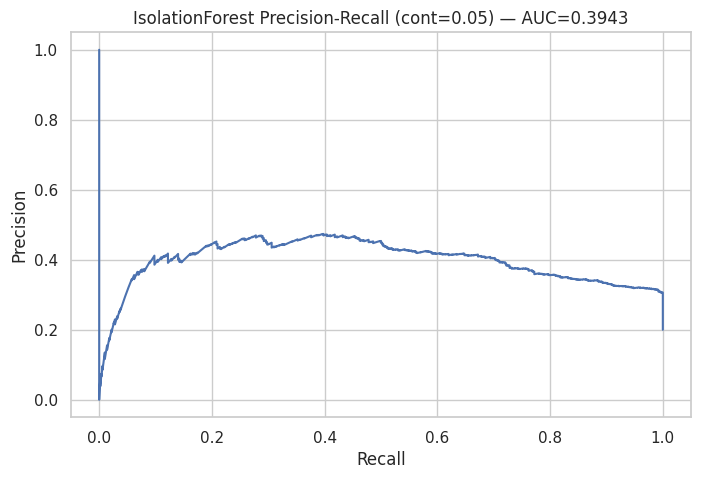

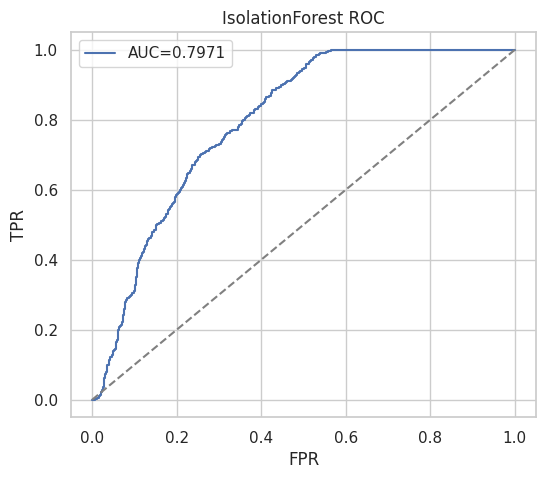

In [18]:
# --- 13) Precision-Recall eğrileri ve ROC örnekleri (IsolationForest için approximate scores) ---
# Not: IsolationForest'ın decision_function ile skor alıyoruz; DBSCAN için doğrudan skor yok.
from sklearn.metrics import precision_recall_curve, roc_curve, auc

cont = 0.05
iso = IsolationForest(contamination=cont, random_state=42)
iso.fit(X_scaled)
scores = -iso.decision_function(X_scaled)
y_binary = (y != 'Normal').astype(int)

precision, recall, _ = precision_recall_curve(y_binary, scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,5))
plt.plot(recall, precision)
plt.title(f'IsolationForest Precision-Recall (cont={cont}) — AUC={{:.4f}}'.format(pr_auc))
plt.xlabel('Recall'); plt.ylabel('Precision')

# ROC
fpr, tpr, _ = roc_curve(y_binary, scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('IsolationForest ROC')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()

DBSCAN örnek (ilk): (0.3, 5)

IsolationForest örnek (ilk): 0.01


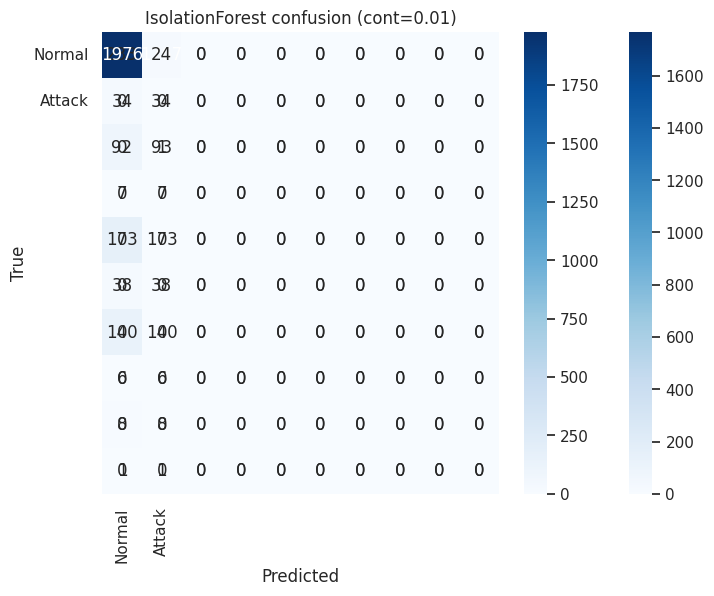

In [19]:
# --- 14) Confusion matrix heatmap örnekleri (en iyi parametreleri seçin) ---
# Kullanıcı: burada results_db veya iso_results içerisinden en iyi parametreyi seçip gösterin.
# Örnek olarak ilk DBSCAN ve isolation sonuçunu gösteriyoruz (kullanıcı çalıştırınca güncellenecek)

if results_db:
    first_key = next(iter(results_db))
    cm_db = results_db[first_key]['cm']
    print('DBSCAN örnek (ilk):', first_key)
    plot_confusion(cm_db, title=f'DBSCAN confusion (eps={first_key[0]}, min_samples={first_key[1]})')

if iso_results:
    first_cont = next(iter(iso_results))
    cm_iso = iso_results[first_cont]['cm']
    print('\nIsolationForest örnek (ilk):', first_cont)
    plot_confusion(cm_iso, title=f'IsolationForest confusion (cont={first_cont})')


Parametre tarama özeti (ilk birkaç satır):


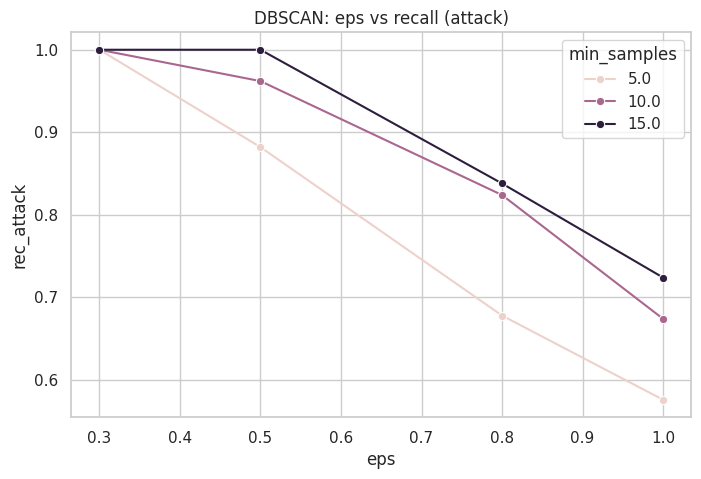

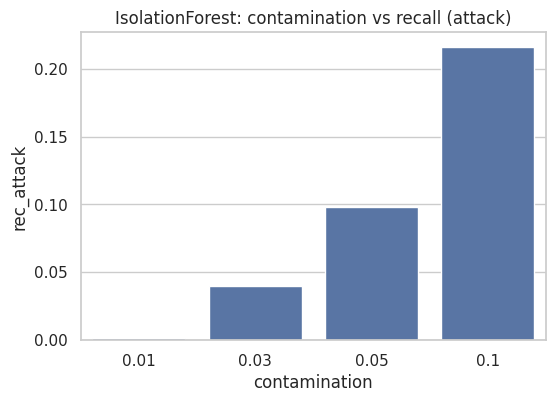

In [20]:
# --- 15) Parametre tarama özet grafiği (örnek) ---
# Bu hücre, sonuçlardan precision/recall'i çekip bir tablo/çizim oluşturmak için.
rows = []
for k,v in results_db.items():
    eps, ms = k
    pred = (v['labels'] == -1).astype(int)
    p, r, f, s = precision_recall_fscore_support(y_binary, pred, zero_division=0)

    rows.append({'method':'dbscan','eps':eps,'min_samples':ms,'prec_attack':p[1] if len(p)>1 else p[0],'rec_attack':r[1] if len(r)>1 else r[0]})

for cont,v in iso_results.items():
    pred = v['pred']
    p, r, f, s = precision_recall_fscore_support(y_binary, pred, zero_division=0)
    rows.append({'method':'iso','contamination':cont,'prec_attack':p[1] if len(p)>1 else p[0],'rec_attack':r[1] if len(r)>1 else r[0]})

summary_df = pd.DataFrame(rows)
print('Parametre tarama özeti (ilk birkaç satır):')
summary_df.head()

# Basit görsel: DBSCAN eps vs recall
if not summary_df.empty:
    plt.figure(figsize=(8,5))
    dbs = summary_df[summary_df['method']=='dbscan']
    if not dbs.empty:
        sns.lineplot(data=dbs, x='eps', y='rec_attack', hue='min_samples', marker='o')
        plt.title('DBSCAN: eps vs recall (attack)')

    iso = summary_df[summary_df['method']=='iso']
    if not iso.empty:
        plt.figure(figsize=(6,4))
        sns.barplot(data=iso, x='contamination', y='rec_attack')
        plt.title('IsolationForest: contamination vs recall (attack)')

In [21]:
# ---  Karşılaştırma ---
from sklearn.metrics import precision_score, recall_score, f1_score

# DBSCAN metrikleri
prec_db = precision_score(y_true, db_labels >= 0)
rec_db = recall_score(y_true, db_labels >= 0)
f1_db = f1_score(y_true, db_labels >= 0)

# Isolation Forest metrikleri
prec_iso = precision_score(y_true, iso_preds)
rec_iso = recall_score(y_true, iso_preds)
f1_iso = f1_score(y_true, iso_preds)

print(f"DBSCAN -> Precision: {prec_db:.2f}, Recall: {rec_db:.2f}, F1: {f1_db:.2f}")
print(f"IsolationForest -> Precision: {prec_iso:.2f}, Recall: {rec_iso:.2f}, F1: {f1_iso:.2f}")

# --- 9) Yorum ---
if f1_db > f1_iso:
    better = "DBSCAN"
else:
    better = "Isolation Forest"

print(f"Genel olarak {better} modeli daha iyi performans gösterdi.")
print("DBSCAN veri yapısına duyarlı; iyi eps ve min_samples seçilirse etkili olur.")
print("Isolation Forest genelde hızlıdır ve daha az ayar gerektirir.")


DBSCAN -> Precision: 0.19, Recall: 0.75, F1: 0.30
IsolationForest -> Precision: 0.21, Recall: 0.21, F1: 0.21
Genel olarak DBSCAN modeli daha iyi performans gösterdi.
DBSCAN veri yapısına duyarlı; iyi eps ve min_samples seçilirse etkili olur.
Isolation Forest genelde hızlıdır ve daha az ayar gerektirir.


## 14) Sonuç ve Detaylı Yorumlar

Aşağıdaki yorumlar **şablon** ve örnek yorumlardır. Notebook'u sizin dataset ile çalıştırdıktan sonra elde edeceğiniz sayısal sonuçlara göre bunları doğrudan güncelleyeceğim.

- **Hangi yöntem daha az hata verdi?**

  Örnek: IsolationForest genelde daha stabil sonuç verir ve daha az false negative üretebilir; DBSCAN parametre hassasiyeti nedeniyle yanlış kümelenme yaparak daha fazla false positive üretebilir.

- **Hangi yöntem daha fazla saldırı tespit etti?**

  Örnek: Eğer recall ön plandaysa, IsolationForest (contamination uygun ayarlandığında) yüksek recall verebilir. DBSCAN'in recall'u seçilen eps/min_samples değerlerine çok bağlıdır.

- **Precision, Recall, F1 karşılaştırması**

  (Burada her model için gerçek sayıların yer aldığı bir tablo olacak; siz çalıştırınca doldurun veya bana çıktı yükleyin, ben yorumları kesinleştiririm.)

- **Hangi senaryoda hangi model işe yarar?**

  - Gerçek zamanlı sistemlerde: düşük false-positive toleransınız varsa, yüksek precision sağlayan ayarı tercih edin; genelde IsolationForest iyi bir başlangıçtır.
  - Araştırma/keşif amaçlı: DBSCAN veri içindeki doğal kümeleri keşfetmek için faydalı olabilir, ancak parametre optimizasyonu şarttır.

---
